In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from tqdm import tqdm
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
import seaborn as sns

In [2]:
"""

walking = A
jogging = B
stairs = C
sitting = D
standing = E
typing = F
teeth = G
soup = H
chips = I
pasta = J
drinking = K
sandwich = L
kicking = M
catch = O
dribbling = P
writing = Q
clapping = R
folding = S

"""
ACTIVITY_MAP = {
    'A': 'walking',
    'B': 'jogging',
    'C': 'stairs',
    'D': 'sitting',
    'E': 'standing',
    'F': 'typing',
    'G': 'teeth',
    'H': 'soup',
    'I': 'chips',
    'J': 'pasta',
    'K': 'drinking',
    'L': 'sandwich',
    'M': 'kicking',
    'O': 'catch',
    'P': 'dribbling',
    'Q': 'writing',
    'R': 'clapping',
    'S': 'folding'
}

ACTIVITY_CODE = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6,
    'H': 7,
    'I': 8,
    'J': 9,
    'K': 10,
    'L': 11,
    'M': 12,
    'O': 13,
    'P': 14,
    'Q': 15,
    'R': 16,
    'S': 17
}

In [3]:
def load_data(subject_id, device, sensor):
    filepath = f'../dataset/{device}_csv/{sensor}/data_{subject_id}_{sensor}_{device}.csv'
    df = pd.read_csv(filepath)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ns')
    df['activity_code'] = df['activity_code'].map(ACTIVITY_CODE)
    return df

subject_1600_data = load_data('1600', 'phone', 'accel')

print(f"Total data shape for subject 1600: {subject_1600_data.shape}")

subject_1600_data.head()

Total data shape for subject 1600: (64311, 6)


,subject_id,activity_code,timestamp,x,y,z
0,1600,0,1970-01-03 22:03:27.666810782,-0.364761,8.793503,1.055084
1,1600,0,1970-01-03 22:03:27.717164786,-0.879730,9.768784,1.016998
2,1600,0,1970-01-03 22:03:27.767518790,2.001495,11.109070,2.619156
3,1600,0,1970-01-03 22:03:27.817872794,0.450623,12.651642,0.184555
4,1600,0,1970-01-03 22:03:27.868226798,-2.164352,13.928436,-4.422485


Total segments found: 18
   subject_id  activity_code  timestamp         x          y         z
0        1600              0   0.000000 -0.364761   8.793503  1.055084
1        1600              0   0.050354 -0.879730   9.768784  1.016998
2        1600              0   0.100708  2.001495  11.109070  2.619156
3        1600              0   0.151062  0.450623  12.651642  0.184555
4        1600              0   0.201416 -2.164352  13.928436 -4.422485
Segment 1 shape: (3574, 6)


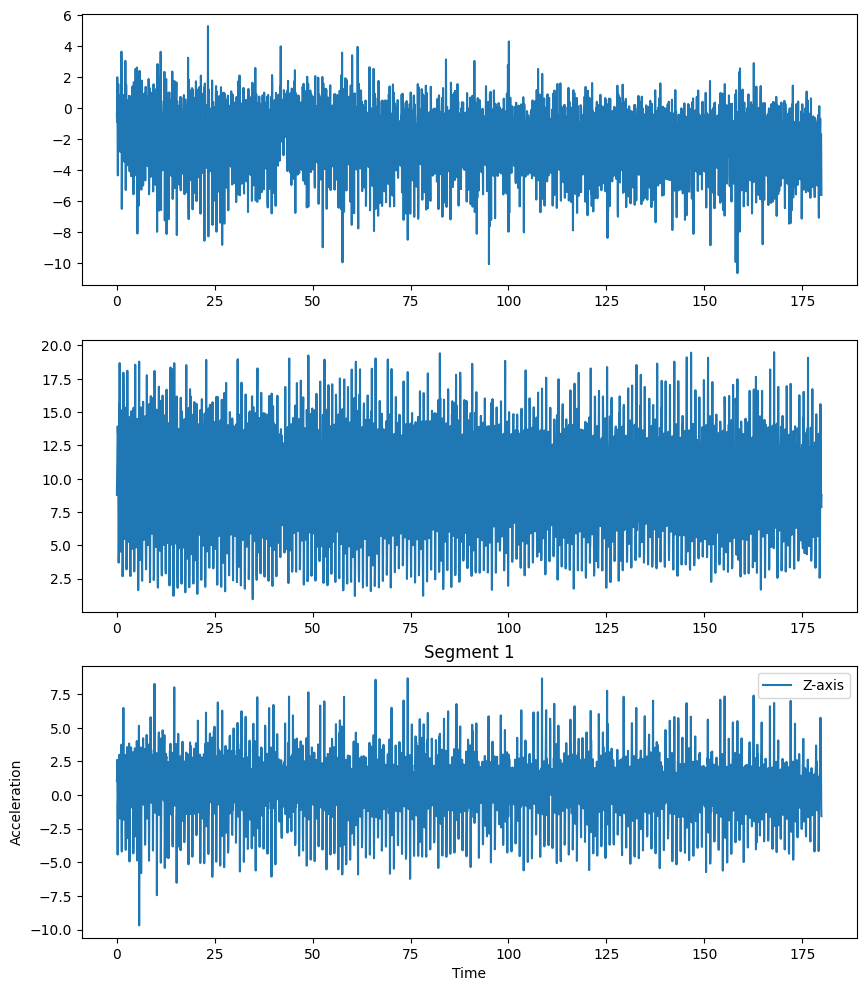

Segment 2 shape: (3572, 6)


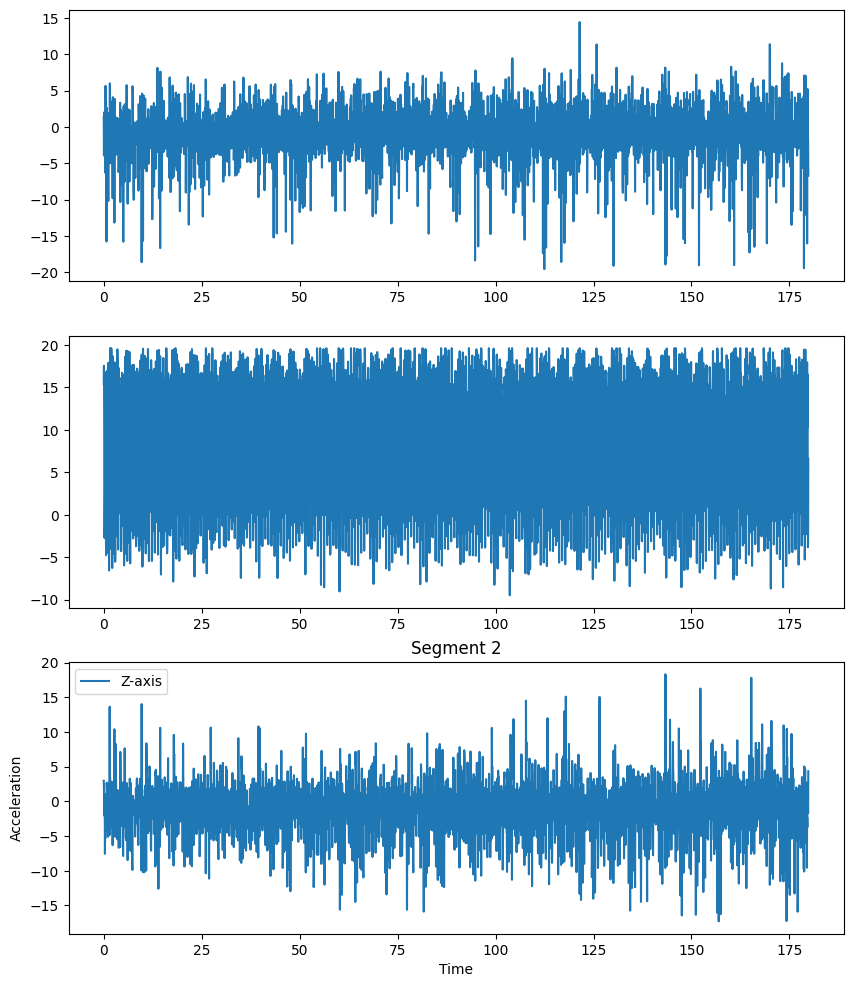

In [4]:
def split_df_into_segments(df, time_col='timestamp', threshold=pd.Timedelta('1s')):
    time_diffs = df[time_col].diff().fillna(pd.Timedelta(seconds=0))
    segment_ids = (abs(time_diffs) > threshold).cumsum()
    segments = [group.reset_index(drop=True) for _, group in df.groupby(segment_ids)]
    for segment in segments:
        segment['timestamp'] = (segment[time_col] - segment[time_col].min()).dt.total_seconds()

    return segments

segments = split_df_into_segments(subject_1600_data)

print(f"Total segments found: {len(segments)}")
print(segments[0].head())

for i, segment in enumerate(segments[:2]):
    print(f"Segment {i+1} shape: {segment.shape}")
    plt.figure(figsize=(10, 12))

    plt.subplot(3, 1, 1)
    plt.plot(segment['timestamp'], segment['x'], label='X-axis')

    plt.subplot(3, 1, 2)
    plt.plot(segment['timestamp'], segment['y'], label='Y-axis')

    plt.subplot(3, 1, 3)
    plt.plot(segment['timestamp'], segment['z'], label='Z-axis')

    plt.title(f'Segment {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.legend()
    plt.show()


In [5]:
def create_windowed_dataseries(segment, window_size=10, step_size=5):
    windows = []
    assert segment['activity_code'].nunique() == 1, "Segment contains multiple activities."
    for start in range(0, len(segment) - window_size + 1, step_size):
        window = segment.iloc[start:start + window_size].copy()
        xs = window['x'].values
        ys = window['y'].values
        zs = window['z'].values
        window_np = np.concatenate([xs, ys, zs], axis=0)
        window_df = pd.DataFrame([window_np], columns=[f'feat_{i}' for i in range(len(window_np))])
        activity_df = pd.DataFrame(np.zeros((1, len(ACTIVITY_CODE)), np.uint8), columns=[f'activity_{i}' for i in range(len(ACTIVITY_CODE))])
        activity_df[f'activity_{segment["activity_code"].iloc[0]}'] = 1
        window_df = pd.concat([window_df, activity_df], axis=1)
        windows.append(window_df)

    return pd.concat(windows, ignore_index=True)

windowed_data = create_windowed_dataseries(segments[0], window_size=10, step_size=5)
windowed_data.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,activity_8,activity_9,activity_10,activity_11,activity_12,activity_13,activity_14,activity_15,activity_16,activity_17
0,-0.364761,-0.879730,2.001495,0.450623,-2.164352,-4.332779,-0.319443,1.566452,-0.323746,-1.811676,...,0,0,0,0,0,0,0,0,0,0
1,-4.332779,-0.319443,1.566452,-0.323746,-1.811676,-1.134049,0.092911,-1.036316,0.752304,-0.496979,...,0,0,0,0,0,0,0,0,0,0
2,-1.134049,0.092911,-1.036316,0.752304,-0.496979,-2.359375,0.580170,-2.812180,-1.885391,0.889343,...,0,0,0,0,0,0,0,0,0,0
3,-2.359375,0.580170,-2.812180,-1.885391,0.889343,0.004822,-0.401566,-1.371719,3.651398,1.651108,...,0,0,0,0,0,0,0,0,0,0
4,0.004822,-0.401566,-1.371719,3.651398,1.651108,-6.492264,-2.365341,0.568207,0.140884,-2.257034,...,0,0,0,0,0,0,0,0,0,0


In [6]:
class HARDataset(Dataset):
    def __init__(self, subjects, device, sensor, window_size=10, step_size=5, shuffle=True):
        segments = []
        for subject_id in tqdm(subjects):
            df = load_data(subject_id, device, sensor)
            segments.extend(split_df_into_segments(df))

        if shuffle:
            np.random.shuffle(segments)

        windows = []
        for segment in tqdm(segments):
            windowed_segment = create_windowed_dataseries(segment, window_size, step_size)
            windows.append(windowed_segment)

        self.data = pd.concat(windows, ignore_index=True)
        self.length = len(self.data)

    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        features = row.filter(like='feat_').values.astype(np.float32).reshape(3, -1)
        labels = row.filter(like='activity_').values.astype(np.float32)
        return features, labels


In [7]:
subjects = [f'16{str(i).zfill(2)}' for i in range(0, 51)]
print(subjects)

# dataset = HARDataset(subjects, device='phone', sensor='accel', window_size=20, step_size=10)

['1600', '1601', '1602', '1603', '1604', '1605', '1606', '1607', '1608', '1609', '1610', '1611', '1612', '1613', '1614', '1615', '1616', '1617', '1618', '1619', '1620', '1621', '1622', '1623', '1624', '1625', '1626', '1627', '1628', '1629', '1630', '1631', '1632', '1633', '1634', '1635', '1636', '1637', '1638', '1639', '1640', '1641', '1642', '1643', '1644', '1645', '1646', '1647', '1648', '1649', '1650']


In [11]:
# torch.save(dataset, '../dataset/har_dataset_phone_accel.pt')
dataset = torch.load('../dataset/har_dataset_phone_accel.pt', weights_only=False)

In [13]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.1, random_state=42)

train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=False)

In [17]:
class HARCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(HARCNN, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(in_channels=3, out_channels=128, kernel_size=11, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Flatten()
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x


  2%|▏         | 15/674 [00:00<00:04, 147.89it/s]

100%|██████████| 674/674 [00:03<00:00, 179.54it/s]


Epoch [1/500], Train Loss: 1.8603, Val Loss: 1.4650, Val Acc: 0.4888


100%|██████████| 674/674 [00:03<00:00, 179.03it/s]


Epoch [2/500], Train Loss: 1.4213, Val Loss: 1.1655, Val Acc: 0.5918


100%|██████████| 674/674 [00:03<00:00, 177.79it/s]


Epoch [3/500], Train Loss: 1.2228, Val Loss: 0.9926, Val Acc: 0.6558


100%|██████████| 674/674 [00:03<00:00, 178.73it/s]


Epoch [4/500], Train Loss: 1.1117, Val Loss: 0.9386, Val Acc: 0.6736


100%|██████████| 674/674 [00:03<00:00, 179.10it/s]


Epoch [5/500], Train Loss: 1.0341, Val Loss: 0.8937, Val Acc: 0.6903


100%|██████████| 674/674 [00:03<00:00, 178.98it/s]


Epoch [6/500], Train Loss: 0.9769, Val Loss: 0.8281, Val Acc: 0.7126


100%|██████████| 674/674 [00:03<00:00, 178.82it/s]


Epoch [7/500], Train Loss: 0.9293, Val Loss: 0.8170, Val Acc: 0.7192


100%|██████████| 674/674 [00:03<00:00, 179.31it/s]


Epoch [8/500], Train Loss: 0.8938, Val Loss: 0.7639, Val Acc: 0.7384


100%|██████████| 674/674 [00:03<00:00, 179.48it/s]


Epoch [9/500], Train Loss: 0.8643, Val Loss: 0.7812, Val Acc: 0.7326


100%|██████████| 674/674 [00:03<00:00, 179.48it/s]


Epoch [10/500], Train Loss: 0.8353, Val Loss: 0.7323, Val Acc: 0.7506


100%|██████████| 674/674 [00:03<00:00, 179.45it/s]


Epoch [11/500], Train Loss: 0.8132, Val Loss: 0.7593, Val Acc: 0.7458


100%|██████████| 674/674 [00:03<00:00, 180.01it/s]


Epoch [12/500], Train Loss: 0.7930, Val Loss: 0.7270, Val Acc: 0.7512


100%|██████████| 674/674 [00:03<00:00, 178.86it/s]


Epoch [13/500], Train Loss: 0.7731, Val Loss: 0.7559, Val Acc: 0.7427


100%|██████████| 674/674 [00:03<00:00, 179.01it/s]


Epoch [14/500], Train Loss: 0.7511, Val Loss: 0.7559, Val Acc: 0.7453


100%|██████████| 674/674 [00:03<00:00, 179.16it/s]


Epoch [15/500], Train Loss: 0.7405, Val Loss: 0.7196, Val Acc: 0.7641


100%|██████████| 674/674 [00:03<00:00, 178.91it/s]


Epoch [16/500], Train Loss: 0.7237, Val Loss: 0.7192, Val Acc: 0.7632


100%|██████████| 674/674 [00:03<00:00, 179.36it/s]


Epoch [17/500], Train Loss: 0.7120, Val Loss: 0.7099, Val Acc: 0.7723


100%|██████████| 674/674 [00:03<00:00, 179.46it/s]


Epoch [18/500], Train Loss: 0.6916, Val Loss: 0.7292, Val Acc: 0.7658


100%|██████████| 674/674 [00:03<00:00, 179.26it/s]


Epoch [19/500], Train Loss: 0.6850, Val Loss: 0.7092, Val Acc: 0.7727


100%|██████████| 674/674 [00:03<00:00, 179.56it/s]


Epoch [20/500], Train Loss: 0.6703, Val Loss: 0.7084, Val Acc: 0.7712


100%|██████████| 674/674 [00:03<00:00, 179.64it/s]


Epoch [21/500], Train Loss: 0.6611, Val Loss: 0.7043, Val Acc: 0.7738


100%|██████████| 674/674 [00:03<00:00, 179.36it/s]


Epoch [22/500], Train Loss: 0.6523, Val Loss: 0.7251, Val Acc: 0.7707


100%|██████████| 674/674 [00:03<00:00, 179.81it/s]


Epoch [23/500], Train Loss: 0.6414, Val Loss: 0.7274, Val Acc: 0.7746


100%|██████████| 674/674 [00:03<00:00, 179.29it/s]


Epoch [24/500], Train Loss: 0.6343, Val Loss: 0.7151, Val Acc: 0.7736


100%|██████████| 674/674 [00:03<00:00, 179.24it/s]


Epoch [25/500], Train Loss: 0.6258, Val Loss: 0.7148, Val Acc: 0.7783


100%|██████████| 674/674 [00:03<00:00, 178.94it/s]


Epoch [26/500], Train Loss: 0.6149, Val Loss: 0.7601, Val Acc: 0.7692


100%|██████████| 674/674 [00:03<00:00, 178.80it/s]


Epoch [27/500], Train Loss: 0.6081, Val Loss: 0.7303, Val Acc: 0.7787


100%|██████████| 674/674 [00:03<00:00, 178.66it/s]


Epoch [28/500], Train Loss: 0.6021, Val Loss: 0.7521, Val Acc: 0.7722


100%|██████████| 674/674 [00:03<00:00, 179.39it/s]


Epoch [29/500], Train Loss: 0.5895, Val Loss: 0.7401, Val Acc: 0.7863


100%|██████████| 674/674 [00:03<00:00, 178.69it/s]


Epoch [30/500], Train Loss: 0.5834, Val Loss: 0.7486, Val Acc: 0.7760


100%|██████████| 674/674 [00:03<00:00, 178.29it/s]


Epoch [31/500], Train Loss: 0.5813, Val Loss: 0.7356, Val Acc: 0.7868


100%|██████████| 674/674 [00:03<00:00, 179.75it/s]


Epoch [32/500], Train Loss: 0.5718, Val Loss: 0.7433, Val Acc: 0.7875


100%|██████████| 674/674 [00:03<00:00, 179.32it/s]


Epoch [33/500], Train Loss: 0.5618, Val Loss: 0.7814, Val Acc: 0.7788


100%|██████████| 674/674 [00:03<00:00, 178.88it/s]


Epoch [34/500], Train Loss: 0.5625, Val Loss: 0.7544, Val Acc: 0.7886


100%|██████████| 674/674 [00:03<00:00, 179.73it/s]


Epoch [35/500], Train Loss: 0.5541, Val Loss: 0.7579, Val Acc: 0.7904


100%|██████████| 674/674 [00:03<00:00, 179.59it/s]


Epoch [36/500], Train Loss: 0.5454, Val Loss: 0.7685, Val Acc: 0.7908


100%|██████████| 674/674 [00:03<00:00, 178.64it/s]


Epoch [37/500], Train Loss: 0.5412, Val Loss: 0.7885, Val Acc: 0.7917


100%|██████████| 674/674 [00:03<00:00, 178.84it/s]


Epoch [38/500], Train Loss: 0.5369, Val Loss: 0.7778, Val Acc: 0.7892


100%|██████████| 674/674 [00:03<00:00, 178.98it/s]


Epoch [39/500], Train Loss: 0.5303, Val Loss: 0.7745, Val Acc: 0.7917


100%|██████████| 674/674 [00:03<00:00, 178.82it/s]


Epoch [40/500], Train Loss: 0.5211, Val Loss: 0.7766, Val Acc: 0.7965


100%|██████████| 674/674 [00:03<00:00, 178.32it/s]


Epoch [41/500], Train Loss: 0.5243, Val Loss: 0.8025, Val Acc: 0.7899
Early stopping triggered.


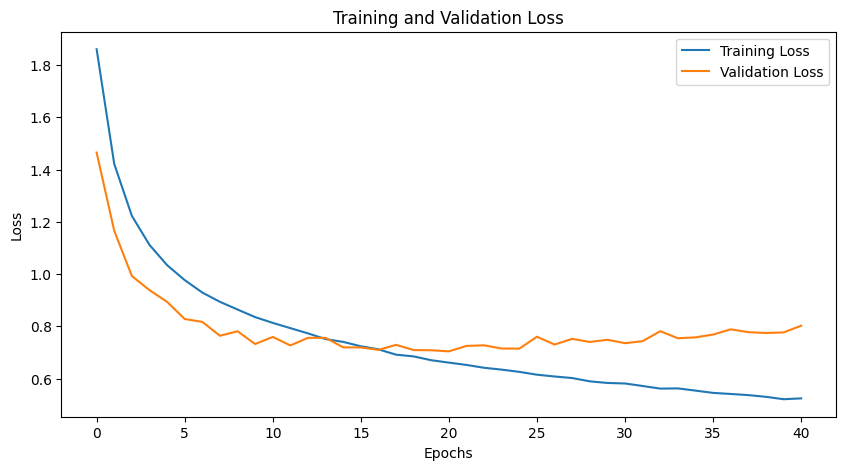

In [18]:
model = HARCNN(input_size=20, num_classes=len(ACTIVITY_CODE)).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

training_loss = []
validation_loss = []
best_val_loss = float('inf')
best_model_state = None
epochs = 500
patience = 20
patience_counter = 0

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for features, labels in tqdm(train_dataloader):
        features = features.to('cuda')
        labels = labels.to('cuda')
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    training_loss.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    total_val_accuracy = 0
    with torch.no_grad():
        for features, labels in val_dataloader:
            features = features.to('cuda')
            labels = labels.to('cuda')
            outputs = model(features)
            loss = criterion(outputs, labels)
            accuracy = (outputs.argmax(dim=1) == labels.argmax(dim=1)).float().mean()
            total_val_accuracy += accuracy.item()
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    avg_val_accuracy = total_val_accuracy / len(val_dataloader)

    validation_loss.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

              precision    recall  f1-score   support

     walking       0.91      0.92      0.92      5500
     jogging       0.94      0.95      0.95      5337
      stairs       0.77      0.77      0.77      4935
     sitting       0.87      0.84      0.85      5369
    standing       0.80      0.80      0.80      5538
      typing       0.83      0.90      0.86      4873
       teeth       0.86      0.88      0.87      5533
        soup       0.74      0.76      0.75      5458
       chips       0.76      0.82      0.79      5158
       pasta       0.85      0.78      0.81      4992
    drinking       0.81      0.77      0.79      5748
    sandwich       0.82      0.80      0.81      5307
     kicking       0.60      0.59      0.59      5508
       catch       0.57      0.59      0.58      5331
   dribbling       0.71      0.67      0.69      5439
     writing       0.91      0.83      0.87      5250
    clapping       0.84      0.86      0.85      5201
     folding       0.67    

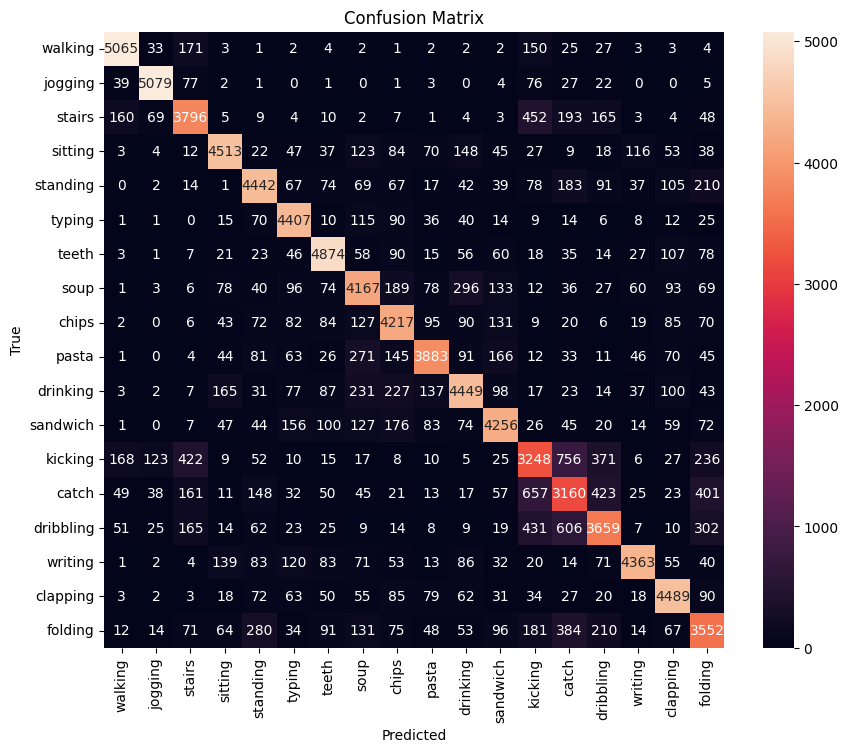

In [16]:
# Load the best model state
model.load_state_dict(best_model_state)

# Evaluate on test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for features, labels in test_dataloader:
        features = features.to('cuda')
        labels = labels.to('cuda')

        labels = torch.argmax(labels, dim=1)

        outputs = model(features)
        predicted = torch.argmax(outputs, dim=1)

        all_preds.append(predicted.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_labels = np.concat(all_labels, axis=0)
all_preds = np.concat(all_preds, axis=0)

print(classification_report(all_labels, all_preds, target_names=[ACTIVITY_MAP[key] for key in ACTIVITY_CODE.keys()]))
conf_mat = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=[ACTIVITY_MAP[key] for key in ACTIVITY_CODE.keys()], yticklabels=[ACTIVITY_MAP[key] for key in ACTIVITY_CODE.keys()])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# Save the model file to disk
torch.save(model, '../models/har_cnn_model.pth')